# Description of the Problem

* In this competition, you will be predicting the number of open_channels present, based on electrophysiological signal data. Electrophysiological involves measurements of voltage changes or electric current or manipulations on a wide variety of scales from single ion channel proteins to whole organs like the heart

What are ion channels:

* Ion channels are pore-forming membrane proteins that allow ions to pass through the channel pore. Their functions include establishing a resting membrane potential, shaping action potentials and other electrical signals by gating the flow of ions across the cell membrane, controlling the flow of ions across secretory and epithelial cells, and regulating cell volume. Ion channels are present in the membranes of all excitable cells. Ion channels are one of the two classes of ionophoric proteins, the other being ion transporters (https://en.wikipedia.org/wiki/Ion_channel)

* In non scientific words their are a kind of protein that are on the outside of the cell and control the access of ions (there are a lot of proteins in a cell, this is just one type)
    

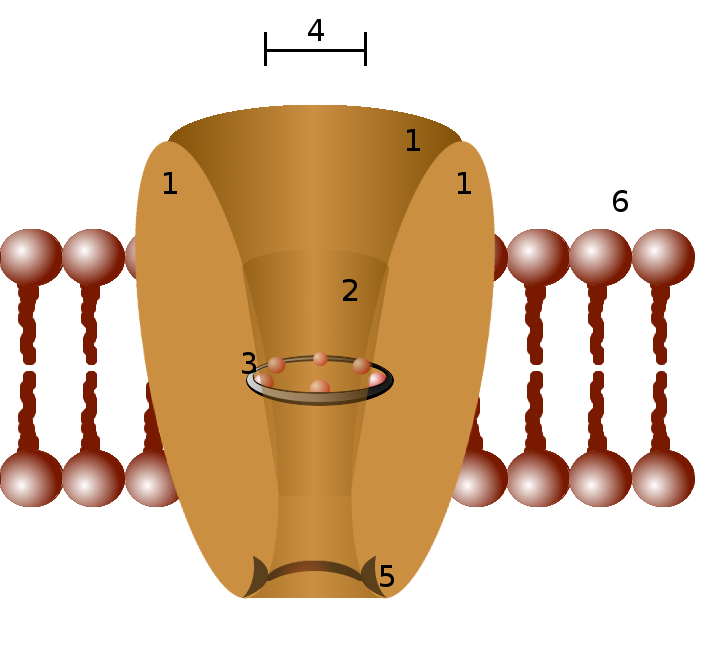

Schematic diagram of an ion channel:
* 1 - channel domains (typically four per channel), 
* 2 - outer vestibule, 
* 3 - selectivity filter, 
* 4 - diameter of selectivity filter, 
* 5 - phosphorylation site, 
* 6 - cell membrane.

Their are 11 channels (from 0 to 10) and the metric for evaluating our model is weighted cohen kappa.

Another important factor of the data is the following:

IMPORTANT: While the time series appears continuous, the data is from discrete batches of 50 seconds long 10 kHz samples (500,000 rows per batch). In other words, the data from 0.0001 - 50.0000 is a different batch than 50.0001 - 100.0000, and thus discontinuous between 50.0000 and 50.0001.

We have different batches of information were each second contains 10000 examples. 

Simple math is 50 seconds * 10000 = 500000 rows

We have discontinuos data!!

In [ ]:
import numpy as np 
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import cohen_kappa_score, accuracy_score, mean_squared_error
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
def read_data():
    print('Reading training, testing and submission data...')
    train = pd.read_csv('/kaggle/input/liverpool-ion-switching/train.csv')
    test = pd.read_csv('/kaggle/input/liverpool-ion-switching/test.csv')
    submission = pd.read_csv('/kaggle/input/liverpool-ion-switching/sample_submission.csv', dtype={'time':str})
    print('Train set has {} rows and {} columns'.format(train.shape[0], train.shape[1]))
    print('Test set has {} rows and {} columns'.format(test.shape[0], test.shape[1]))
    return train, test, submission

train, test, submission = read_data()

In [ ]:
# Let's check the data
batch = 50 # batches of 50 seconds long
print('In the training data we {} batches'.format(train['time'].max() / batch))
print('In the testing data we {} batches'.format((test['time'].max() / batch - (train['time'].max() / batch))))
total_batches = (test['time'].max() / batch + (train['time'].max() / batch))
pd.concat([train.head(), train.tail()])

We have 10 batches of training data and 4 batches of testing data. Let's make a new column to identify each batch

In [ ]:
# concatenate data
train['set'] = 'train'
test['set'] = 'test'
data = pd.concat([train, test])
for i in range(int(total_batches)):
    data.loc[(data['time'] > i * batch) & (data['time'] <= (i + 1) * batch), 'batch'] = i + 1
train = data[data['set'] == 'train']
test = data[data['set'] == 'test']
del data

# Target Variable Distribution

In [ ]:
plt.figure(figsize = (12, 8))
sns.countplot(train['open_channels'])
plt.xlabel('Open Channels', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

* Channels 0, 1 and 3 are the most common
* Channel 10 has only 0.0071 of the participation
* The four most common channels represent 69% of the observations

In [ ]:
batch1 = train[train["batch"] == 1]
batch2 = train[train["batch"] == 2]
batch3 = train[train["batch"] == 3]
batch4 = train[train["batch"] == 4]
batch5 = train[train["batch"] == 5]
batch6 = train[train["batch"] == 6]
batch7 = train[train["batch"] == 7]
batch8 = train[train["batch"] == 8]
batch9 = train[train["batch"] == 9]
batch10 = train[train["batch"] == 10]
fig, axes = plt.subplots(5, 2, figsize = (14, 12))
sns.countplot(batch1['open_channels'], color = 'red', ax = axes[0][0])
sns.countplot(batch2['open_channels'], color = 'green', ax = axes[0][1])
sns.countplot(batch3['open_channels'], color = 'blue', ax = axes[1][0])
sns.countplot(batch4['open_channels'], color = 'yellow', ax = axes[1][1])
sns.countplot(batch5['open_channels'], color = 'brown', ax = axes[2][0])
sns.countplot(batch6['open_channels'], color = 'pink', ax = axes[2][1])
sns.countplot(batch7['open_channels'], color = 'orange', ax = axes[3][0])
sns.countplot(batch8['open_channels'], color = 'purple', ax = axes[3][1])
sns.countplot(batch9['open_channels'], color = 'gold', ax = axes[4][0])
sns.countplot(batch10['open_channels'], color = 'silver', ax = axes[4][1])

for i in range(5):
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
        
axes[0][0].set_title('Batch 1 Target Distribution', fontsize=13)
axes[0][1].set_title('Batch 2 Target Distribution', fontsize=13)
axes[1][0].set_title('Batch 3 Target Distribution', fontsize=13)
axes[1][1].set_title('Batch 4 Target Distribution', fontsize=13)
axes[2][0].set_title('Batch 5 Target Distribution', fontsize=13)
axes[2][1].set_title('Batch 6 Target Distribution', fontsize=13)
axes[3][0].set_title('Batch 7 Target Distribution', fontsize=13)
axes[3][1].set_title('Batch 8 Target Distribution', fontsize=13)
axes[4][0].set_title('Batch 9 Target Distribution', fontsize=13)
axes[4][1].set_title('Batch 10 Target Distribution', fontsize=13)
plt.tight_layout()
plt.show()

* A lot of the batches don't have all of the classes. 
* Batch 1, 2, 3, 7 have only class 0 and 1
* Batch 4 and 8 have only class 0, 1, 2, 3
* Batch 6 and 9 have only class 0, 1, 2, 3, 4, 5
* Batch 5 and 10 have only class 0, 3, 4, 5, 6, 7, 8, 9, 10

It's look like this batches are married :). 

* Batch 1 and 2
* Batch 3 and 7
* Batch 4 and 8
* Batch 5 and 10
* Batch 6 and 9

In [ ]:
batch11 = test[test["batch"] == 11]
batch12 = test[test["batch"] == 12]
batch13 = test[test["batch"] == 13]
batch14 = test[test["batch"] == 14]

fig, axes = plt.subplots(7, 2, figsize = (16, 14))
sns.lineplot(batch1['time'], batch1['signal'], color = 'red', ax = axes[0][0])
sns.lineplot(batch2['time'], batch2['signal'], color = 'green', ax = axes[0][1])
sns.lineplot(batch3['time'], batch3['signal'], color = 'blue', ax = axes[1][0])
sns.lineplot(batch4['time'], batch4['signal'], color = 'yellow', ax = axes[1][1])
sns.lineplot(batch5['time'], batch5['signal'], color = 'brown', ax = axes[2][0])
sns.lineplot(batch6['time'], batch6['signal'], color = 'pink', ax = axes[2][1])
sns.lineplot(batch7['time'], batch7['signal'], color = 'orange', ax = axes[3][0])
sns.lineplot(batch8['time'], batch8['signal'], color = 'purple', ax = axes[3][1])
sns.lineplot(batch9['time'], batch9['signal'], color = 'gold', ax = axes[4][0])
sns.lineplot(batch10['time'], batch10['signal'], color = 'silver', ax = axes[4][1])
sns.lineplot(batch11['time'], batch11['signal'], color = 'skyblue', ax = axes[5][0])
sns.lineplot(batch12['time'], batch12['signal'], color = 'darkviolet', ax = axes[5][1])
sns.lineplot(batch13['time'], batch13['signal'], color = 'deeppink', ax = axes[6][0])
sns.lineplot(batch14['time'], batch14['signal'], color = 'crimson', ax = axes[6][1])

for i in range(7):
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
        
axes[0][0].set_title('Batch 1 Signal', fontsize=13)
axes[0][1].set_title('Batch 2 Signal', fontsize=13)
axes[1][0].set_title('Batch 3 Signal', fontsize=13)
axes[1][1].set_title('Batch 4 Signal', fontsize=13)
axes[2][0].set_title('Batch 5 Signal', fontsize=13)
axes[2][1].set_title('Batch 6 Signal', fontsize=13)
axes[3][0].set_title('Batch 7 Signal', fontsize=13)
axes[3][1].set_title('Batch 8 Signal', fontsize=13)
axes[4][0].set_title('Batch 9 Signal', fontsize=13)
axes[4][1].set_title('Batch 10 Signal', fontsize=13)
axes[5][0].set_title('Batch 11 Signal', fontsize=13)
axes[5][1].set_title('Batch 12 Signal', fontsize=13)
axes[6][0].set_title('Batch 13 Signal', fontsize=13)
axes[6][1].set_title('Batch 14 Signal', fontsize=13)
plt.tight_layout()
plt.show()

* Batch 2 has a strange behaviour in the first 10 seconds
* Batch 8 has some rare peaks
* Batches that have a similar distribution of the target variable have different signal distribution.
* Batch 11 and 12 has a wired behaviour (test set)

# Signal Channel Distribution

In [ ]:
channel0 = train[train["open_channels"] == 0]
channel1 = train[train["open_channels"] == 1]
channel2 = train[train["open_channels"] == 2]
channel3 = train[train["open_channels"] == 3]
channel4 = train[train["open_channels"] == 4]
channel5 = train[train["open_channels"] == 5]
channel6 = train[train["open_channels"] == 6]
channel7 = train[train["open_channels"] == 7]
channel8 = train[train["open_channels"] == 8]
channel9 = train[train["open_channels"] == 9]
channel10 = train[train["open_channels"] == 10]
fig, axes = plt.subplots(6, 2, figsize = (15, 13))
sns.distplot(channel0['signal'], color = 'red', ax = axes[0][0])
sns.distplot(channel1['signal'], color = 'green', ax = axes[0][1])
sns.distplot(channel2['signal'], color = 'blue', ax = axes[1][0])
sns.distplot(channel3['signal'], color = 'yellow', ax = axes[1][1])
sns.distplot(channel4['signal'], color = 'brown', ax = axes[2][0])
sns.distplot(channel5['signal'], color = 'pink', ax = axes[2][1])
sns.distplot(channel6['signal'], color = 'orange', ax = axes[3][0])
sns.distplot(channel7['signal'], color = 'purple', ax = axes[3][1])
sns.distplot(channel8['signal'], color = 'gold', ax = axes[4][0])
sns.distplot(channel9['signal'], color = 'silver', ax = axes[4][1])
sns.distplot(channel10['signal'], color = 'black', ax = axes[5][0])

for i in range(5):
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
        
axes[0][0].set_title('Open Channel 0 Target Distribution', fontsize=13)
axes[0][1].set_title('Open Channel 1 Target Distribution', fontsize=13)
axes[1][0].set_title('Open Channel 2 Target Distribution', fontsize=13)
axes[1][1].set_title('Open Channel 3 Target Distribution', fontsize=13)
axes[2][0].set_title('Open Channel 4 Target Distribution', fontsize=13)
axes[2][1].set_title('Open Channel 5 Target Distribution', fontsize=13)
axes[3][0].set_title('Open Channel 6 Target Distribution', fontsize=13)
axes[3][1].set_title('Open Channel 7 Target Distribution', fontsize=13)
axes[4][0].set_title('Open Channel 8 Target Distribution', fontsize=13)
axes[4][1].set_title('Open Channel 9 Target Distribution', fontsize=13)
axes[5][0].set_title('Open Channel 10 Target Distribution', fontsize=13)
plt.tight_layout()
plt.show()

* Channel 0, 1, 2 and 3 have a similar distribution (shape). If you check the x axis you will see an increment for the signal value from 0 to 3
* Channel 4 and 5 have a similar distribution (shape). If you check the x axis you will see an increment for the signal value from 4 to 5
* Channel 6, 7, 8, 9 and 10 have a similar distribution (shape). If you check the x axis you will see an increment for the signal value from 6 to 10

* Channels have different signal distributions!!

# Baseline

Baseline was taken from this script
https://www.kaggle.com/suicaokhoailang/an-embarrassingly-simple-baseline-0-960-lb

In [ ]:
# lazy way to get weighted cohen kappa score 0f 0.96 (PL 30% test data)
# n_groups = 40
# test["group"] = 0
# for i in range(n_groups):
#     ids = np.arange(i*50000, (i+1)*50000)
#     test.loc[ids,"group"] = i
    
# for i in range(n_groups):
#     sub = test[test.group == i]
#     signals = sub.signal.values
#     imax, imin = math.floor(np.max(signals)), math.ceil(np.min(signals))
#     signals = (signals - np.min(signals))/(np.max(signals) - np.min(signals))
#     signals = signals*(imax-imin)
#     test.loc[sub.index,"open_channels"] = np.array(signals,np.int)
    
# submission.open_channels = np.array(test.open_channels, np.int)
# submission.to_csv("submission.csv",index=False)

In [ ]:
# create group (5 seconds each group)
def get_signal_tf(train, test):
    
    train_groups = 100
    train['group'] = 0
    for i in range(train_groups):
        ids = np.arange(i * 50000, (i + 1) * 50000)
        train.loc[ids, 'group'] = i
        
    test_groups = 40
    test['group'] = 0
    for i in range(test_groups):
        ids = np.arange(i * 50000, (i + 1) * 50000)
        test.loc[ids, 'group'] = i
            
    for i in range(train_groups):
        sub = train[train.group == i]
        signals = sub.signal.values
        imax, imin = math.floor(np.max(signals)), math.ceil(np.min(signals))
        signals = (signals - np.min(signals)) / (np.max(signals) - np.min(signals))
        signals = signals * (imax - imin)
        train.loc[sub.index, "signal_tr"] = np.array(signals, np.int)
        
    for i in range(test_groups):
        sub = test[test.group == i]
        signals = sub.signal.values
        imax, imin = math.floor(np.max(signals)), math.ceil(np.min(signals))
        signals = (signals - np.min(signals)) / (np.max(signals) - np.min(signals))
        signals = signals * (imax - imin)
        test.loc[sub.index, "signal_tr"] = np.array(signals, np.int)
        
    return train, test
        
train, test = get_signal_tf(train, test)

In [ ]:
print('Our weighted cohen cappa score is: {}'.format(cohen_kappa_score(train['open_channels'], train['signal_tr'], weights = 'quadratic')))
print('Our cohen cappa score is: {}'.format(cohen_kappa_score(train['open_channels'], train['signal_tr'])))
print('Our accuracy score is: {}'.format(accuracy_score(train['open_channels'], train['signal_tr'])))

In [ ]:
def preprocess(train, test):
    
    pre_train = train.copy()
    pre_test = test.copy()
    
    batch1 = pre_train[pre_train["batch"] == 1]
    batch2 = pre_train[pre_train["batch"] == 2]
    batch3 = pre_train[pre_train["batch"] == 3]
    batch4 = pre_train[pre_train["batch"] == 4]
    batch5 = pre_train[pre_train["batch"] == 5]
    batch6 = pre_train[pre_train["batch"] == 6]
    batch7 = pre_train[pre_train["batch"] == 7]
    batch8 = pre_train[pre_train["batch"] == 8]
    batch9 = pre_train[pre_train["batch"] == 9]
    batch10 = pre_train[pre_train["batch"] == 10]
    batch11 = pre_test[pre_test['batch'] == 11]
    batch12 = pre_test[pre_test['batch'] == 12]
    batch13 = pre_test[pre_test['batch'] == 13]
    batch14 = pre_test[pre_test['batch'] == 14]
    batches = [batch1, batch2, batch3, batch4, batch5, batch6, batch7, batch8, batch9, batch10, batch11, batch12, batch13, batch14]
    for batch in batches:
        for feature in ['signal_tr']:
            # lag feature for 1-10 (just trying some random lags)
            for lag in [1, 2, 3, 4, 5]:
                batch[feature + '_t' + str(lag)] = batch[feature].shift(lag)
            # some random rolling features
            for window in [5, 25, 50, 100, 1000, 5000, 10000, 25000]:
                batch[feature + 'mean_t' + str(window)] = batch[feature].shift(1).rolling(window).mean()
                batch[feature + 'std_t' + str(window)] = batch[feature].shift(1).rolling(window).std()
                batch[feature + 'min_t' + str(window)] = batch[feature].shift(1).rolling(window).min()
                batch[feature + 'max_t' + str(window)] = batch[feature].shift(1).rolling(window).max()
                batch[feature + 'var_t' + str(window)] = batch[feature].shift(1).rolling(window).var()
                
    pre_train = pd.concat([batch1, batch2, batch3, batch4, batch5, batch6, batch7, batch8, batch9, batch10])
    pre_test = pd.concat([batch11, batch12, batch13, batch14])
    
    return pre_train, pre_test

pre_train, pre_test = preprocess(train, test)

In [ ]:
def run_lgb(pre_trian, pre_test, usefull_features, params):
    
    kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
    target = 'open_channels'
    oof_pred = np.zeros(len(pre_train))
    y_pred = np.zeros(len(pre_test))
    feature_importance = pd.DataFrame()
    
    # train a baseline model and record the weighted cohen kappa score 
    for fold, (tr_ind, val_ind) in enumerate(kf.split(pre_train)):
        print('Fold {}'.format(fold + 1))
        x_train, x_val = pre_train[usefull_features].iloc[tr_ind], pre_train[usefull_features].iloc[val_ind]
        y_train, y_val = pre_train[target][tr_ind], pre_train[target][val_ind]
        train_set = lgb.Dataset(x_train, y_train)
        val_set = lgb.Dataset(x_val, y_val)
        
        model = lgb.train(params, train_set, num_boost_round = 3000, early_stopping_rounds = 50, 
                         valid_sets = [train_set, val_set], verbose_eval = 100)
        
        oof_pred[val_ind] = model.predict(x_val)
        
        y_pred += model.predict(pre_test[usefull_features]) / kf.n_splits
        
        # get fold importance df
        fold_importance = pd.DataFrame({'features': usefull_features})
        fold_importance['fold'] = fold + 1
        fold_importance['importance'] = model.feature_importance()
        feature_importance = pd.concat([feature_importance, fold_importance])
        
    # round predictions
    rmse_score = np.sqrt(mean_squared_error(pre_trian[target], oof_pred))
    print('Our oof rmse score is: ', rmse_score)
    oof_pred = np.clip(oof_pred, 0, 10).astype(int)
    y_pred = np.clip(y_pred, 0, 10).astype(int)
    cohen_score = cohen_kappa_score(pre_train[target], oof_pred, weights = 'quadratic')
    print('Our oof cohen kappa score is: ', cohen_score)
    
    # plot feature importance
    fi_mean = feature_importance.groupby(['features'])['importance'].mean().reset_index()
    plt.figure(figsize = (12, 14))
    sns.barplot(x = fi_mean['importance'], y = fi_mean['features'])
    plt.xlabel('Importance', fontsize = 13)
    plt.ylabel('Feature', fontsize = 13)
    plt.tick_params(axis = 'x', labelsize = 11)
    plt.tick_params(axis = 'y', labelsize = 11)
    plt.title('Light Gradient Boosting Feature Importance (5 KFold)')
    plt.show()
    
    
    return oof_pred, y_pred, feature_importance


# define hyperparammeter (some random hyperparammeters)
params = {'learning_rate': 0.1, 
          'feature_fraction': 0.75, 
          'bagging_fraction': 0.75,
          'bagging_freq': 1,
          'n_jobs': -1, 
          'seed': 50,
          'metric': 'rmse'
        }

# define the features for training
features = [col for col in pre_train.columns if col not in ['open_channels', 'set', 'time', 'batch', 'group']]

oof_pred, y_pred, feature_importance = run_lgb(pre_train, pre_test, features, params)

In [ ]:
submission.open_channels = y_pred
submission.to_csv("submission.csv",index=False)